In [483]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
#Loading the dataset
df = pd.read_csv('graded_task_heart_disease.csv')

# Checking for nulls
df.isnull().sum()

#Saving all rows containing NA and imputing with median - to be joined with training set later on
df_na = df[df.isna().any(axis=1)]
df_na = df_na.fillna(df_na.median())

# Dropping rows containing nulls
df.dropna(inplace=True)

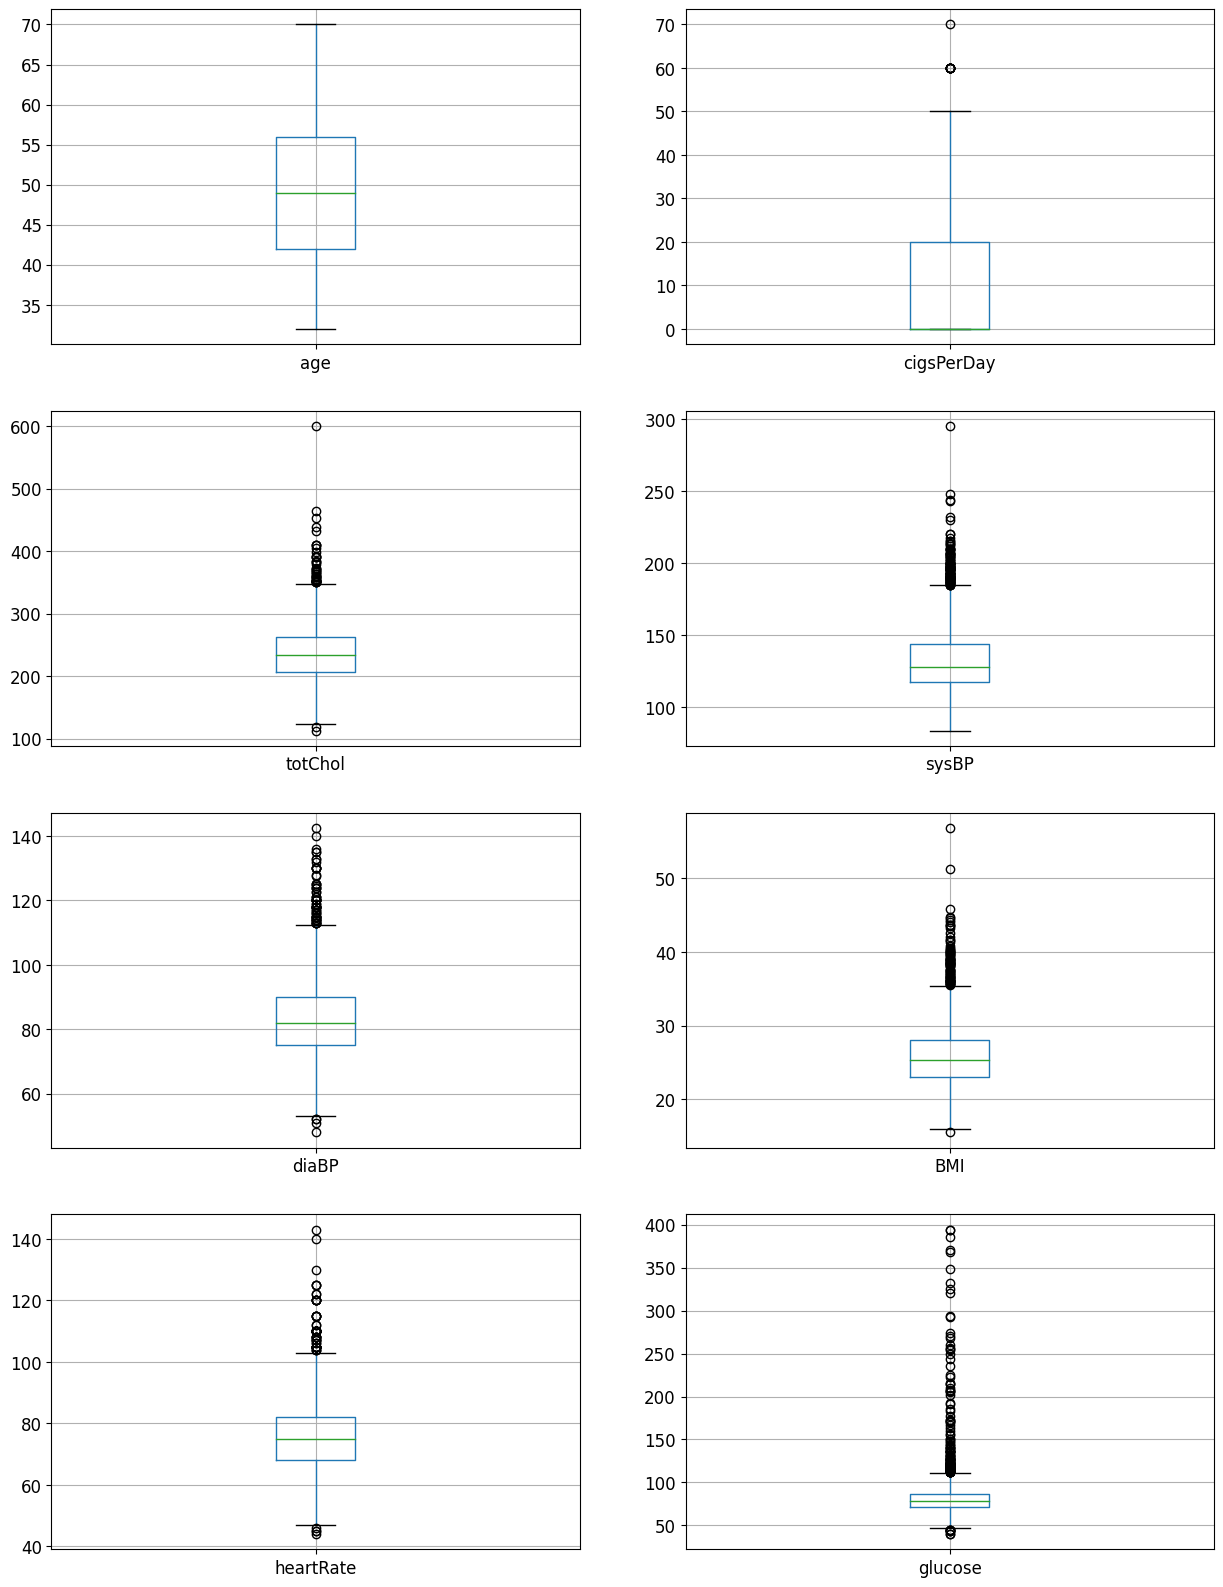

In [484]:
#Boxplots for outlier visualization in continous features
plt.figure(figsize=(15, 20))

continuous_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

index = 0
for name in continuous_features:
  index += 1
  plt.subplot(4, 2, index)
  fig = df.boxplot(column = name)

In [485]:
#Remove outliers from dataframes (using abs(IQR*3) from box as a limit)
print(df.shape)
print(df_na.shape)

def remove_outliers(dataframe, column_name):
  IQR = dataframe[column_name].quantile(0.75) - dataframe[column_name].quantile(0.25)
  lower_limit = dataframe[column_name].quantile(0.25) - (IQR * 3)
  upper_limit = dataframe[column_name].quantile(0.75) + (IQR * 3)
  df_clean = dataframe.loc[~((dataframe[column_name] > upper_limit) | (dataframe[column_name] < lower_limit))]
  return df_clean

for name in continuous_features:
  df = remove_outliers(df, name)
  df_na = remove_outliers(df_na, name)

print(df.shape)
print(df_na.shape)
#About ~100 rows containing outliers eliminated in df and ~180 in df_na

(3656, 16)
(582, 16)
(3567, 16)
(403, 16)


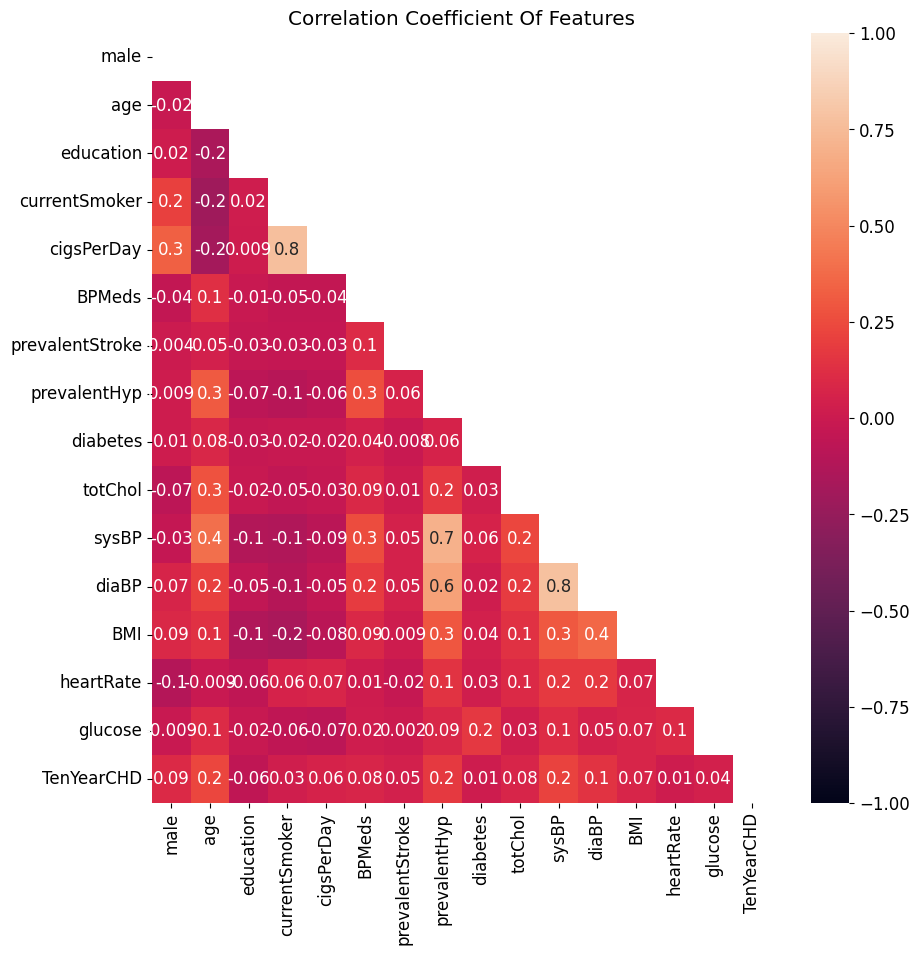

In [486]:
#Check for multicollinearity
plt.figure(figsize=(10, 10))

# Generate a mask to show only the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1, fmt='.1g')
plt.title('Correlation Coefficient Of Features')
plt.show()
#Only a couple of features show correlation with other features - check the VIF

In [487]:
#Calculate VIF values for each feature
'''
A VIF of 1.5 means that the variance is 50% higher than what could be expected
if there was no multicollinearity between the independent variables.
As a general rule of thumb, if the VIF is more than 5, the regression analysis
is said to be highly correlated.
'''
def compute_vif(considered_features):
    #The calculation of variance inflation requires a constant
    x = add_constant(df[considered_features])

    #Create dataframe to store VIF values
    vif = pd.DataFrame()
    vif["Variable"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
    print(x.shape[1])
    return vif


#Features to consider removing
considered_features = ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay',
                       'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes',
                       'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


#Compute VIF
compute_vif(considered_features).sort_values('VIF', ascending=False)
#No features have VIF > 5, so leaving them as is

16


,Variable,VIF
0,const,218.633645
11,sysBP,3.644567
12,diaBP,2.895629
5,cigsPerDay,2.725362
4,currentSmoker,2.573755
8,prevalentHyp,2.085008
2,age,1.365125
13,BMI,1.220702
1,male,1.212421
10,totChol,1.128340


In [488]:
#Split data to training and testing
x = df.drop(['TenYearCHD'], axis=1)
y = df['TenYearCHD']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)

In [446]:
#Enrich the training set with rows containing imputed medians
#DO NOT RUN - Does not improve ROC AUC scores of the model in the end...
x_na = df_na.drop(['TenYearCHD'], axis=1)
y_na = df_na['TenYearCHD']

x_train = pd.concat([x_train, x_na])
y_train = pd.concat([y_train, y_na])

In [489]:
#Check the split and cols for use in the scaler
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
cols = x_train.columns

(2853, 15) (714, 15) (2853,) (714,)


In [490]:
#Scale the feature data to correctly interpretate coefficients
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)
x_train = pd.DataFrame(x_train, columns=[cols])
x_test = pd.DataFrame(x_test, columns=[cols])

In [491]:
#Recursive feature elimination
'''
The process involves developing a model with the remaining features after
repeatedly removing the least significant parts until the desired number
of features is obtained.
In this case - dropping half of the 'insignificant' features.
'''
# - newton-cg solver gave the highest accuracy
# - training with class_weight = 'balanced', because of the imbalanced dataset
model = LogisticRegression(solver='newton-cg', random_state=101, class_weight='balanced')

#Select best features
rfe = RFE(model, n_features_to_select=None)
rfe = rfe.fit(x_train, y_train)

#Summarize the selection of the attributes
remain_feat = x_train.columns[rfe.support_].to_list()
print(remain_feat)

[('male',), ('age',), ('cigsPerDay',), ('BPMeds',), ('prevalentStroke',), ('sysBP',), ('diaBP',)]


In [492]:
#Removes unnecessary features
x_train.drop(columns=[col for col in x_train if col not in remain_feat], inplace=True)
x_test.drop(columns=[col for col in x_test if col not in remain_feat], inplace=True)

In [493]:
#Train the model
model = LogisticRegression(solver='newton-cg', random_state=101, class_weight='balanced', C=6.15)
model.fit(x_train, y_train)

LogisticRegression(C=6.15, class_weight='balanced', random_state=101,
                   solver='newton-cg')

In [494]:
#Predict results and check accuracy scores
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

print('Testing-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Testing-set accuracy score: 0.6961
Training-set accuracy score: 0.6660


In [495]:
#Get coefficients and odd ratios for features
'''
Odds ratios that are greater than 1 indicate that the event is more likely to
occur as the predictor increases. Odds ratios that are less than 1 indicate
that the event is less likely to occur as the predictor increases.
'''
coef_frame = pd.DataFrame({"Feature": x_train.columns.to_list(),
                           "Coefficients": model.coef_[0],
                           "Odd Ratios": np.exp(model.coef_[0])})
coef_frame.loc[len(coef_frame.index)] = ['Intercept', float(model.intercept_), None]
print(coef_frame)

              Feature  Coefficients Odd Ratios
0             (male,)      0.474152   1.606651
1              (age,)      2.418362  11.227458
2       (cigsPerDay,)      1.366388   3.921161
3           (BPMeds,)      0.446414   1.562699
4  (prevalentStroke,)      1.089993   2.974255
5            (sysBP,)      1.983560   7.268575
6            (diaBP,)      0.165825   1.180367
7           Intercept     -2.514710       None


In [496]:
#Regularization parameter C tuning (the best is C=6.15)
'''
Why log loss is important? For example, imagine having 2 models that both
predict one observation correctly (CHD=1). However, 1 model has a
predicted probability of 0.54 and the other 0.95. Which one will you choose?
Classification Accuracy will not help here as it will get both on 100%
'''
#Creating and looping over multiple C parameters to find the one which gives highest acc and lowest log_loss
c_list = np.geomspace(1e-5, 1e5, num=20)
ca = []
logarithmic_loss = []

for c in c_list:
    log_reg = LogisticRegression(random_state=101, solver = 'newton-cg', C=c, class_weight='balanced')
    log_reg.fit(x_train, y_train)
    score = log_reg.score(x_test, y_test)
    ca.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg.predict_proba(x_test)
    logloss = log_loss(y_test, pred_proba_t)
    logarithmic_loss.append(logloss)
    print("The Logg Loss of C parameter {} is {}:".format(c, logloss)+"\n")

The CA of C parameter 1e-05 is 0.5812324929971989:
The Logg Loss of C parameter 1e-05 is 0.6930529564105776:

The CA of C parameter 3.359818286283781e-05 is 0.5840336134453782:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6928316177726463:

The CA of C parameter 0.00011288378916846884 is 0.5826330532212886:
The Logg Loss of C parameter 0.00011288378916846884 is 0.6920984774046376:

The CA of C parameter 0.000379269019073225 is 0.5840336134453782:
The Logg Loss of C parameter 0.000379269019073225 is 0.6897461875359313:

The CA of C parameter 0.0012742749857031334 is 0.592436974789916:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6828695234153527:

The CA of C parameter 0.004281332398719391 is 0.6218487394957983:
The Logg Loss of C parameter 0.004281332398719391 is 0.666711108098554:

The CA of C parameter 0.01438449888287663 is 0.6414565826330533:
The Logg Loss of C parameter 0.01438449888287663 is 0.6409161242005348:

The CA of C parameter 0.04832930238571752 is 0

In [497]:
#Compare model with the dummy model - null accuracy is the accuracy that could be achieved by always predicting the most frequent class (always class 0)
most_frq_class_count = y_test[y_test == y_test.value_counts().idxmax()].shape[0]
all_class_count = len(y_test)
null_accuracy = (most_frq_class_count/all_class_count)
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))
#We get such high accuracy, because of the imbalanced dataset, if the dataset would be balanced, the dummy accuracy would ~0.5.

Null accuracy score: 0.8613


<Axes: >

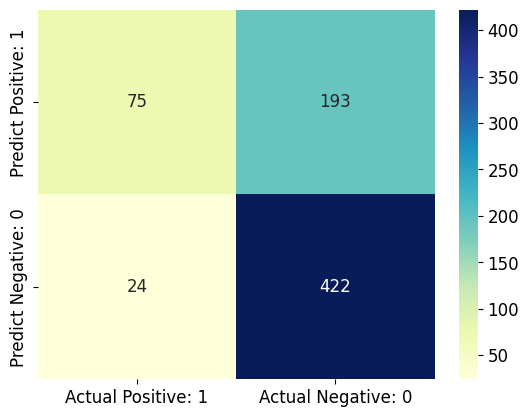

In [498]:
#Prepare confusion a matrix
'''
True Positives (TP) – True Positives occur when we predict an observation
belongs to a certain class and the observation actually belongs to that class.

True Negatives (TN) – True Negatives occur when we predict an observation does
not belong to a certain class and the observation actually does not belong to that class.

False Positives (FP) – False Positives occur when we predict an observation belongs
to a certain class but the observation actually does not belong to that class.
This type of error is called Type I error.

False Negatives (FN) – False Negatives occur when we predict an observation does
not belong to a certain class but the observation actually belongs to that class.
This is a very serious error and it is called Type II error.

These four outcomes are summarized in a confusion matrix given below.
'''
cm = confusion_matrix(y_pred_test, y_test, labels=[1, 0])
cm_matrix = pd.DataFrame(data=cm,
                         columns=['Actual Positive: 1', 'Actual Negative: 0'],
                         index=['Predict Positive: 1', 'Predict Negative: 0'])



sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
#High number of Type II errors - lets try to lower the threshold

In [499]:
#Classification metrics
print(classification_report(y_test, y_pred_test))

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

true_positive_rate = TP / float(TP + FN)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

false_positive_rate = FP / float(FP + TN)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80       615
           1       0.28      0.76      0.41        99

    accuracy                           0.70       714
   macro avg       0.61      0.72      0.60       714
weighted avg       0.85      0.70      0.74       714

Classification accuracy : 0.6961
Classification error : 0.3039
Precision : 0.2799
Recall or Sensitivity : 0.7576
True Positive Rate : 0.7576
False Positive Rate : 0.3138
Specificity : 0.6862


In [502]:
#Finding the optimal threshold level (lowering the threshold minimizes type II errors, but at specificity cost)
y_pred = model.predict_proba(x_test)[:,1]
y_pred = y_pred.reshape(-1,1)
for i in range(1,10):
    y_pred2 = binarize(y_pred, threshold=i/10)
    cm1 = confusion_matrix(y_pred2, y_test, labels=[1, 0])
    print ('With', i/10,'threshold the Confusion Matrix is ','\n\n', cm1,'\n\n',
            'with', cm1[0,0]+cm1[1,1], 'correct predictions, ', '\n\n',
            cm1[0,1], 'Type I errors (False Positives), ','\n\n',
            cm1[1,0], 'Type II errors (False Negatives), ','\n\n',
           'Accuracy score: ', (accuracy_score(y_test, y_pred2)), '\n\n',
           'Sensitivity: ', cm1[0,0]/(float(cm1[0,0]+cm1[1,0])), '\n\n',
           'Specificity: ', cm1[1,1]/(float(cm1[1,1]+cm1[0,1])),'\n\n',
            '====================================================', '\n\n')

With 0.1 threshold the Confusion Matrix is  

 [[ 99 615]
 [  0   0]] 

 with 99 correct predictions,  

 615 Type I errors (False Positives),  

 0 Type II errors (False Negatives),  

 Accuracy score:  0.13865546218487396 

 Sensitivity:  1.0 

 Specificity:  0.0 



With 0.2 threshold the Confusion Matrix is  

 [[ 99 565]
 [  0  50]] 

 with 149 correct predictions,  

 565 Type I errors (False Positives),  

 0 Type II errors (False Negatives),  

 Accuracy score:  0.20868347338935575 

 Sensitivity:  1.0 

 Specificity:  0.08130081300813008 



With 0.3 threshold the Confusion Matrix is  

 [[ 98 435]
 [  1 180]] 

 with 278 correct predictions,  

 435 Type I errors (False Positives),  

 1 Type II errors (False Negatives),  

 Accuracy score:  0.38935574229691877 

 Sensitivity:  0.98989898989899 

 Specificity:  0.2926829268292683 



With 0.4 threshold the Confusion Matrix is  

 [[ 92 343]
 [  7 272]] 

 with 364 correct predictions,  

 343 Type I errors (False Positives), 

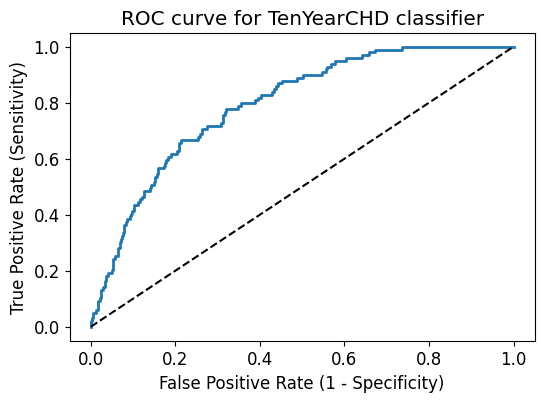

In [503]:
#Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for TenYearCHD classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [504]:
#Calculate area under curve
'''
In this technique, we measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier
will have a ROC AUC equal to 0.5.
'''
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
print('ROC AUC: {:.4f}'.format(roc_auc))

ROC AUC: 0.7950


In [505]:
#Calculate 5 times cross-validated ROC AUC
cross_val_roc_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(cross_val_roc_auc))
#Original model score is found to be 0.7950. The average cross-validation score is 0.7128. So, we can conclude that cross-validation does not result in performance improvement.

Cross validated ROC AUC : 0.7128


In [ ]:
#Model parameter tuning using GridSearch (searched for better parameters using this - however, uses k-fold cross validation)
c_list = np.geomspace(1e-5, 1e5, num=20)
parameters = [{'C':c_list},
              {'penalty':['l2', None]},
              {'class_weight':['balanced', None]}]

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 5,
                           verbose = 1)

grid_search.fit(x_train, y_train)
print("Tuned hyperparameters:", grid_search.best_params_)
print("ROC AUC score:", grid_search.best_score_)
print("Best estimator found by grid search:", grid_search.best_estimator_)

Conclusions

1. The model was trained on 80% of the data and tested on 20%. At first it had 15 features and had to predict a binary result.

2. By recursively eliminating half of the features that were less 'significant' the ROC AUC score of the model was increased from 0.7811 to 0.7884. The features that were left were -'male', 'age', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'sysBP', 'diaBP'. Those same features tended to have higher abs(coeficient) values as well, which means they had more weight in model decisiveness.

3. The model shows no signs of overfitting. As accuracy for train and test datasets are almost identical.

4. Training data was not balanced and contained more class 0 outcomes than class 1. Therefore, the class 0 was predicted better than class 1 at first, which ultimatelly led to minimal sensitivity value (0.0404) at 0.5 threshold.

Undersampling with NearMiss and Oversampling with SMOTE did not help to solve this issue, as it resulted in lower ROC AUC scores both times and lower sensitivities (0.0101 both times compared to 0.0404 at 0.5 threshold).

LogisticRegression parameter class_weight='balanced' helped to increase model's ROC AUC to 0.7950. It is supposed to help in the cases of imbalanced datasets by automatically adjusting weights inversely proportional to class frequencies in the input data.

5. Imputation of NA values with median in the dataset and using it in the training did not help to achieve better ROC AUC scores.

6. Model's accuracy highly depends on the threshold we choose. If this model is supposed to be the first step in diagnostic procedure, then it is crucial to avoid false negatives in my opinion. I would suggest using 0.29 threshold eliminate false negatives in total. Etc.:

                  With 0.29 threshold the Confusion Matrix is  

                    99 457
                    0 158

                  with 257 correct predictions,  

                  457 Type I errors (False Positives),  

                  0 Type II errors (False Negatives),  

                  Accuracy score:  0.3599439775910364

                  Sensitivity:  1.0

                  Specificity:  0.25691056910569104


 This way we totally eliminate false negatives and the increased false positives could be put in a 'high - risk' group and eliminated in further diagnostic steps by conducting medical tests in real life. It's always better to get a false negative than a false positive when it comes to disease.

 However, if the false positives would end up too costly, then the threshold could be raised to allow more accuracy in cost of increased false negatives.

 7. ROC AUC of our model approaches towards 1. So, we can conclude that our classifier does a better job than flipping a coin does.

 References:
 This work has been highly influenced by:
 https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial/notebook